#Import

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils.layer_utils import count_params
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras.models import Sequential, Model
import math
import pickle 
import seaborn as sns
import re
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import matplotlib.cm as cm
import time

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/MyDrive"

Mounted at /content/gdrive


In [ ]:
dataset = os.path.join(root_dir, "SigNature/Datasets/SigNature_integration_HQ_augmented_2")
pickle_path = dataset + "/SigNature_integr_HQ_augmented_tailored.pickle"

Dataset is imported this way: x_train, x_val, x_test contain images, y_01 contain Forged/Genuine labels, while y_id contain ids of the relative user.



In [ ]:
x_train, y_01_train, y_id_train = [], [], []
x_test, y_01_test, y_id_test = [], [], []
x_val, y_01_val, y_id_val = [], [], []

This is the function to load the dataset from scratch, and to save the pickle file to the relative path

In [ ]:
def load_slow():
  data_dir = os.path.join(dataset, "Train")
  data_dir_test = os.path.join(dataset, "Test")

  content = os.listdir(data_dir)
  n = len(content) // 2
  n_train = int(n * 0.8)

  for folder in tqdm(os.listdir(data_dir)):
    is_genuine = 0 if "forged" in folder else 1
    user_id = int(re.findall('\d+', folder)[0])
    path = os.path.join(data_dir, folder)
    n_imgs = len(os.listdir(path))
    n_val = n_imgs - 5
    #n_val = math.ceil(0.1 * n_imgs)
    
    if user_id >= n_train:
      for i in range(n_val):
        img_path = os.path.join(data_dir, folder, os.listdir(path)[i])
        img_obj = cv2.imread(img_path, 0)
        img_obj = np.array(img_obj).astype("float32") / 255
        x_val.append(img_obj)
        y_01_val.append(is_genuine)
        y_id_val.append(user_id)
      for i in range(n_val, n_imgs):
        img_path = os.path.join(data_dir, folder, os.listdir(path)[i])
        img_obj = cv2.imread(img_path, 0)
        img_obj = np.array(img_obj).astype("float32") / 255
        x_train.append(img_obj)
        y_01_train.append(is_genuine)
        y_id_train.append(user_id)
    
  for folder in tqdm(os.listdir(data_dir_test)):
    is_genuine = 0 if "forged" in folder else 1
    user_id = int(re.findall('\d+', folder)[0])
    path = os.path.join(data_dir_test, folder)
  
    if user_id >= n_train:
      for img in os.listdir(path):
        img_path = os.path.join(data_dir_test, folder, img)
        img_obj = cv2.imread(img_path, 0)
        img_obj = np.array(img_obj).astype("float32") / 255
        x_test.append(img_obj)
        y_01_test.append(is_genuine)
        y_id_test.append(user_id)

  f = open(pickle_path, "wb") 
  pickle.dump([(x_train, y_01_train, y_id_train),
               (x_test, y_01_test, y_id_test),
               (x_val, y_01_val, y_id_val)], f)
  f.close()

This is the function to load the dataset from the pickle file

In [ ]:
def load_fast():
  f = open(pickle_path, "rb") 
  train_set, test_set, val_set = pickle.load(f)
  f.close()
  return train_set, test_set, val_set

In [ ]:
if os.path.isfile(pickle_path): 
  train_set, test_set, val_set = load_fast()
  x_train, y_01_train, y_id_train = train_set
  x_test, y_01_test, y_id_test = test_set
  x_val, y_01_val, y_id_val = val_set
else: 
  load_slow()

In [ ]:
data_dir = os.path.join(dataset, "Train")
content = os.listdir(data_dir)
n = len(content) // 2
n_train = int(n * 0.8)

print(len(x_train) / (n - n_train + 1))

10.0


## Preparing the data
---



Only 2 classes are needed: forged and genuine

In [ ]:
num_classes = 2

One hot encoding of the classes

In [ ]:
y_01_test = keras.utils.to_categorical(y_01_test, num_classes)
y_01_train = keras.utils.to_categorical(y_01_train, num_classes)
y_01_val = keras.utils.to_categorical(y_01_val, num_classes)

Espand dimensions for the CNN model input, the new correct shape is:
 128 x 256 x 1



In [ ]:
x_test = np.expand_dims(x_test, -1)
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)

input_shape = (128, 256, 1)

Shuffle randomly the dataset to not bias the model in training phase

In [ ]:
x_train, y_01_train, y_id_train = shuffle(x_train, y_01_train, y_id_train)
x_test, y_01_test, y_id_test = shuffle(x_test, y_01_test, y_id_test)
x_val, y_01_val, y_id_val = shuffle(x_val, y_01_val, y_id_val)

#Tailored model

Here we define some functions to calculate the f1_m to import the basic model correctly, and to use it during the training.

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
fBestModel_reduced = dataset + '/basic_model.h5'
dependencies = {
    'f1_m': f1_m
}
model = keras.models.load_model(fBestModel_reduced, custom_objects=dependencies)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 30, 128)      0

### Classical Network

After taking the features, we will train a **"classical" model**.

Here is a list of the **hyper-parameters** used to tune the "classical" network:
*   optimizer: adam
*   activation function: relu
*   output function: sigmoid 
*   loss function: binary crossentropy 
*   learning rate: 0.00001
*   batch size: 4
*   number of epochs: 500



In [ ]:
seed = 0
nb_classes = 2
n_epochs1 = 500
batch_size1 = 4

def init_classical_model(input_shape):
  initializer = tf.keras.initializers.GlorotUniform(seed=seed) 
  classical_model = keras.Sequential(
      [
       keras.Input(shape=input_shape),
       layers.Flatten(),
       layers.Dense(521, activation="relu", kernel_initializer=initializer),
       layers.Dropout(0.4, seed = 0),
       layers.Dense(512, activation="relu", kernel_initializer=initializer),
       layers.Dropout(0.4, seed = 0),
       layers.Dense(256, activation="relu", kernel_initializer=initializer),
       layers.Dropout(0.4, seed = 0),
       layers.Dense(128, activation="relu", kernel_initializer=initializer),
       layers.Dense(nb_classes, activation="sigmoid", kernel_initializer=initializer)
      ]
  )

  classical_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy',metrics=['accuracy', f1_m])
  return classical_model

###Split by Id

In [ ]:
data_dir = os.path.join(dataset, "Train")

content = os.listdir(data_dir)
n = len(content) // 2
n_train = int(n * 0.8)

In [ ]:
tailored_grouped_by_id_train = {}
for i in range(len(x_train)):
  if not y_id_train[i] in tailored_grouped_by_id_train:
    tailored_grouped_by_id_train[y_id_train[i]] = [[],[],[]]
  tailored_grouped_by_id_train[y_id_train[i]][0].append(x_train[i])
  tailored_grouped_by_id_train[y_id_train[i]][1].append(y_01_train[i])
  tailored_grouped_by_id_train[y_id_train[i]][2].append(y_id_train[i])


In [ ]:
tailored_grouped_by_id_val = {}
for i in range(len(x_val)):
  if not y_id_val[i] in tailored_grouped_by_id_val:
    tailored_grouped_by_id_val[y_id_val[i]] = [[],[],[]]
  tailored_grouped_by_id_val[y_id_val[i]][0].append(x_val[i])
  tailored_grouped_by_id_val[y_id_val[i]][1].append(y_01_val[i])
  tailored_grouped_by_id_val[y_id_val[i]][2].append(y_id_val[i])

In [ ]:
tailored_grouped_by_id_test = {}
for i in range(len(x_test)):
  if not y_id_test[i] in tailored_grouped_by_id_test:
    tailored_grouped_by_id_test[y_id_test[i]] = [[],[],[]]
  tailored_grouped_by_id_test[y_id_test[i]][0].append(x_test[i])
  tailored_grouped_by_id_test[y_id_test[i]][1].append(y_01_test[i])
  tailored_grouped_by_id_test[y_id_test[i]][2].append(y_id_test[i])

In [ ]:
for id in range(n_train, n+1):
  tailored_grouped_by_id_train[id][0] = np.expand_dims(tailored_grouped_by_id_train[id][0], -1)
  tailored_grouped_by_id_test[id][0] = np.expand_dims(tailored_grouped_by_id_test[id][0], -1)
  tailored_grouped_by_id_val[id][0] = np.expand_dims(tailored_grouped_by_id_val[id][0], -1)
  
  tailored_grouped_by_id_train[id][1] = np.expand_dims(tailored_grouped_by_id_train[id][1], -1)
  tailored_grouped_by_id_test[id][1] = np.expand_dims(tailored_grouped_by_id_test[id][1], -1)
  tailored_grouped_by_id_val[id][1] = np.expand_dims(tailored_grouped_by_id_val[id][1], -1)
  
  tailored_grouped_by_id_train[id][2] = np.expand_dims(tailored_grouped_by_id_train[id][2], -1)
  tailored_grouped_by_id_test[id][2] = np.expand_dims(tailored_grouped_by_id_test[id][2], -1)
  tailored_grouped_by_id_val[id][2] = np.expand_dims(tailored_grouped_by_id_val[id][2], -1)

###Features extraction

In [ ]:
model1 = Model(inputs=model.input, outputs=model.get_layer('dense').output)
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 60, 128)       7385

In [ ]:
features_1_train = {}
for id in range(n_train, n+1):
  features_1_train[id] = model1.predict(tailored_grouped_by_id_train[id][0])

In [ ]:
features_1_val = {}
for id in range(n_train, n+1):
  features_1_val[id] = model1.predict(tailored_grouped_by_id_val[id][0])

In [ ]:
features_1_test = {}
for id in range(n_train, n+1):
  features_1_test[id] = model1.predict(tailored_grouped_by_id_test[id][0])

In [ ]:
for id in range(n_train, n+1):
  tailored_grouped_by_id_train[id][1] = tailored_grouped_by_id_train[id][1][:, :, 0]
  tailored_grouped_by_id_val[id][1] = tailored_grouped_by_id_val[id][1][:, :, 0]
  tailored_grouped_by_id_test[id][1] = tailored_grouped_by_id_test[id][1][:, :, 0]

###Training

In [ ]:
models_1 = {}
for id in range(n_train, n+1):
  models_1[id] = init_classical_model(features_1_train[id].shape[1])

In [ ]:
models_1[n_train].summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 1024)              0         
                                                                 
 dense_115 (Dense)           (None, 521)               534025    
                                                                 
 dropout_69 (Dropout)        (None, 521)               0         
                                                                 
 dense_116 (Dense)           (None, 512)               267264    
                                                                 
 dropout_70 (Dropout)        (None, 512)               0         
                                                                 
 dense_117 (Dense)           (None, 256)               131328    
                                                                 
 dropout_71 (Dropout)        (None, 256)             

We train each user for 500 epochs. We use a very high number of epochs because we want to understand if it is possibile to generate a model that does not overfit on the long run, so that we can train it as long as we can, hoping to improve generalization performances thanks to the dropout regularization.

In [ ]:
network_history1 = {}

for id in range(n_train, n+1):
  network_history1[id] = models_1[id].fit(features_1_train[id], tailored_grouped_by_id_train[id][1], batch_size=batch_size1, epochs=n_epochs1, verbose=2, validation_data=(features_1_val[id], tailored_grouped_by_id_val[id][1]))

Output streaming troncato alle ultime 5000 righe.
Epoch 1/500
3/3 - 1s - loss: 0.6714 - accuracy: 0.5000 - f1_m: 0.6389 - val_loss: 0.6903 - val_accuracy: 0.5000 - val_f1_m: 0.4911 - 1s/epoch - 416ms/step
Epoch 2/500
3/3 - 0s - loss: 0.7162 - accuracy: 0.5000 - f1_m: 0.5556 - val_loss: 0.6898 - val_accuracy: 0.5000 - val_f1_m: 0.4911 - 207ms/epoch - 69ms/step
Epoch 3/500
3/3 - 0s - loss: 0.7087 - accuracy: 0.5000 - f1_m: 0.4167 - val_loss: 0.6893 - val_accuracy: 0.5000 - val_f1_m: 0.4911 - 208ms/epoch - 69ms/step
Epoch 4/500
3/3 - 0s - loss: 0.6806 - accuracy: 0.5000 - f1_m: 0.5778 - val_loss: 0.6887 - val_accuracy: 0.5000 - val_f1_m: 0.4911 - 145ms/epoch - 48ms/step
Epoch 5/500
3/3 - 0s - loss: 0.7045 - accuracy: 0.5000 - f1_m: 0.5556 - val_loss: 0.6881 - val_accuracy: 0.5000 - val_f1_m: 0.4911 - 207ms/epoch - 69ms/step
Epoch 6/500
3/3 - 0s - loss: 0.6673 - accuracy: 0.5000 - f1_m: 0.5463 - val_loss: 0.6876 - val_accuracy: 0.5000 - val_f1_m: 0.4911 - 130ms/epoch - 43ms/step
Epoch 7/50

## Analyze and comment training results

We will show the training results for a subset of users

User 87


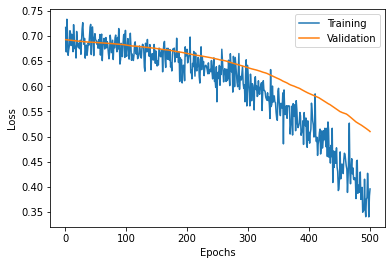

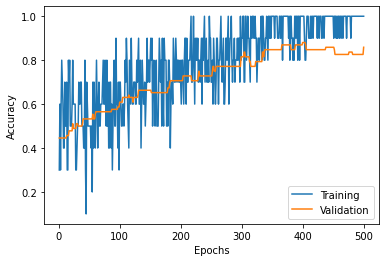

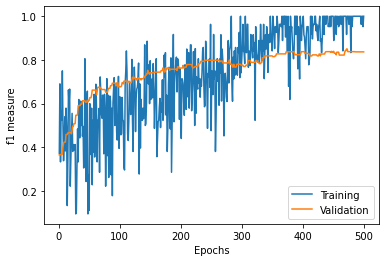

User 88


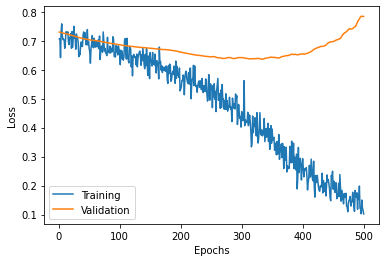

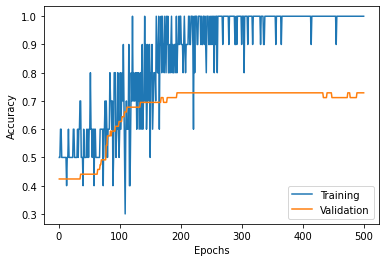

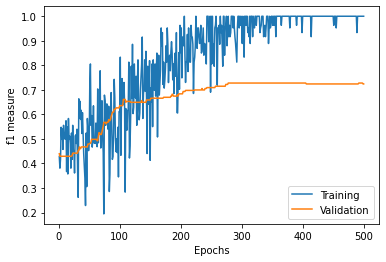

User 89


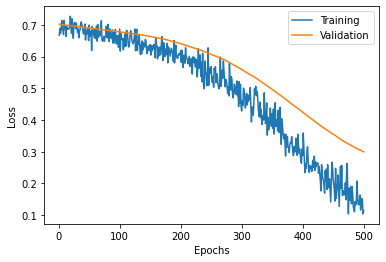

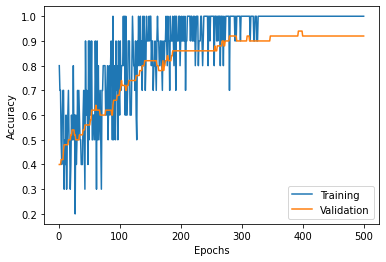

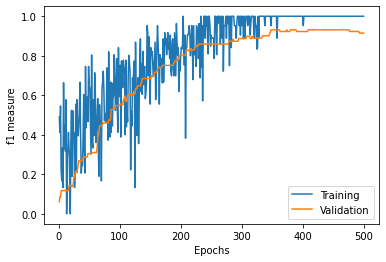

User 90


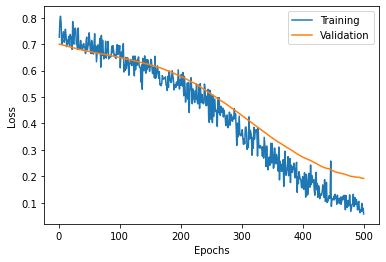

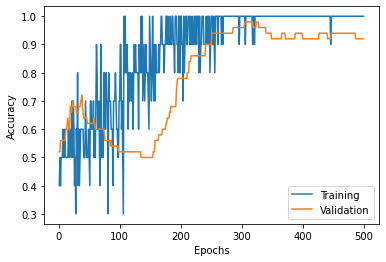

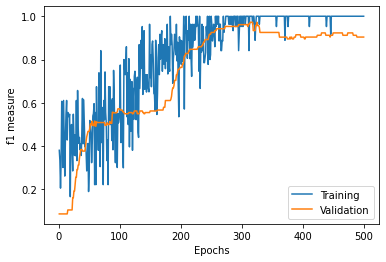

In [ ]:
x_plot = list(range(1,n_epochs1 +1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history['loss'])
    plt.plot(x_plot, network_history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history['accuracy'])
    plt.plot(x_plot, network_history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('f1 measure')
    plt.plot(x_plot, network_history['f1_m'])
    plt.plot(x_plot, network_history['val_f1_m'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

for id in range(87, 91):
  print("User " + str(id))
  plot_history(network_history1[id].history)

###Comments

As we can see the performances on the validation set is good for most users(only the one with id 88 has some problems, further analysis would be necessary to understand this behavior).
We can assume that the generalization capacity of the model should be satisfying.

## Predictions on test set

In [ ]:
for id in range(n_train, n+1):
  score = models_1[id].evaluate(features_1_test[id], tailored_grouped_by_id_test[id][1], verbose=0)
  print("Id ", id)
  print("Test loss", score[0])
  print("Test accuracy", score[1])

Id  87
Test loss 0.5127989649772644
Test accuracy 1.0
Id  88
Test loss 0.5578354597091675
Test accuracy 0.800000011920929
Id  89
Test loss 0.41456449031829834
Test accuracy 1.0
Id  90
Test loss 0.06754367053508759
Test accuracy 1.0
Id  91
Test loss 0.34032514691352844
Test accuracy 0.800000011920929
Id  92
Test loss 0.0754239410161972
Test accuracy 1.0
Id  93
Test loss 0.35814473032951355
Test accuracy 0.75
Id  94
Test loss 0.7027945518493652
Test accuracy 0.75
Id  95
Test loss 0.06182374805212021
Test accuracy 1.0
Id  96
Test loss 0.9103334546089172
Test accuracy 0.5
Id  97
Test loss 0.1378483772277832
Test accuracy 1.0
Id  98
Test loss 0.379625141620636
Test accuracy 1.0
Id  99
Test loss 0.3907300531864166
Test accuracy 1.0
Id  100
Test loss 0.1952943056821823
Test accuracy 1.0
Id  101
Test loss 0.07504234462976456
Test accuracy 1.0
Id  102
Test loss 0.03468633443117142
Test accuracy 1.0
Id  103
Test loss 0.2411283552646637
Test accuracy 0.875
Id  104
Test loss 0.6838401556015015
Tes

In [ ]:
predictions = {}
for id in range(n_train, n+1):
  predictions[id] = np.argmax(models_1[id].predict(features_1_test[id]), axis=1)
  predictions[id] = keras.utils.to_categorical(predictions[id], nb_classes)

Here we show the classification reports for each user. For most users the test results are very good (accuracy of 100%). Other users have some problems.

In [ ]:
from sklearn.metrics import classification_report

for id in range(n_train, n+1):
  print(classification_report(predictions[id], tailored_grouped_by_id_test[id][1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4

   micro avg       1.00      1.00      1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7
 samples avg       1.00      1.00      1.00         7

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

   micro avg       0.80      0.80      0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5
 samples avg       0.80      0.80      0.80         5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         4
   macro avg       1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions_tot = predictions[n_train]

for id in range(n_train+1, n+1):
  predictions_tot = np.concatenate((predictions_tot, predictions[id]))

In [ ]:
real_labels_tot = tailored_grouped_by_id_test[n_train][1]

for id in range(n_train+1, n+1):
  real_labels_tot = np.concatenate((real_labels_tot, tailored_grouped_by_id_test[id][1]))

Here we show the classification report obtained by merging the predictions of all the models.

In [ ]:
print(classification_report(predictions_tot, real_labels_tot, digits=6))

              precision    recall  f1-score   support

           0   0.894737  0.894737  0.894737        76
           1   0.891892  0.891892  0.891892        74

   micro avg   0.893333  0.893333  0.893333       150
   macro avg   0.893314  0.893314  0.893314       150
weighted avg   0.893333  0.893333  0.893333       150
 samples avg   0.893333  0.893333  0.893333       150



## Predictions by user id


In this section is described , for each user, the performance evaluation.
 This is done mainly to undersand who are the users that performs better and worst.

In [ ]:
users_score = []

n = len(os.listdir(dataset + "/Test")) // 2
for i in tqdm(range(n_train, n + 1)):
  x_user_1 = []
  y_user = []

  folder_g = str(i) + "_genuine"
  folder_f = str(i) + "_forged"
  
  for img in os.listdir(dataset + "/Test" + "/" + folder_g):
    path = os.path.join(dataset, "Test", folder_g, img)
    img_obj = cv2.imread(path, 0)
    img_obj = np.array(img_obj).astype("float32") / 255
    x_user_1.append(img_obj)
    y_user.append(1)

  for img in os.listdir(dataset + "/Test" + "/" + folder_f):
    path = os.path.join(dataset, "Test", folder_f, img)
    img_obj = cv2.imread(path, 0)
    img_obj = np.array(img_obj).astype("float32") / 255
    x_user_1.append(img_obj)
    y_user.append(0)

  y_user = keras.utils.to_categorical(y_user, num_classes)
  x_user_1 = np.expand_dims(x_user_1, -1)
  x_user = model1.predict(x_user_1)
  score = models_1[i].evaluate(x_user, y_user, verbose=0)

  predictions = np.argmax(models_1[i].predict(x_user), axis=1)
  predictions = keras.utils.to_categorical(predictions, nb_classes)
  users_score.append((score, classification_report(predictions, y_user, zero_division=0)))

100%|██████████| 23/23 [00:46<00:00,  2.00s/it]


In [ ]:
labels = [ str(i+n_train) for i in range(0, n - n_train)]

users_acc = [users_score[i][0][1] for i in range(0, n - n_train)]
users_f1 = [users_score[i][0][2] for i in range(0, n - n_train)]

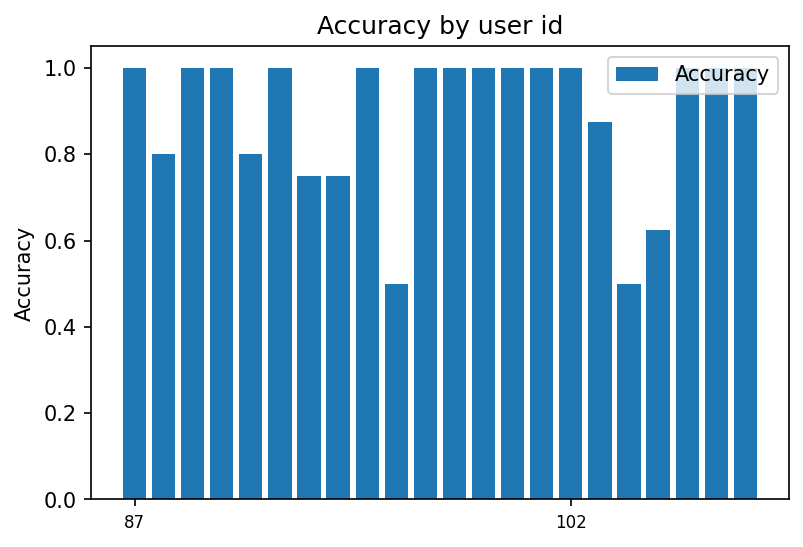

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
ax.bar(labels, users_acc, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by user id')
ax.legend()
fig.set_dpi(150)
plt.xticks(fontsize=8)
ax.set_xticks(np.arange(0, n - n_train, 15))
plt.figure()
plt.show()

In [ ]:
print("Max accuracy:", max(users_acc), "by the user", n_train+users_acc.index(max(users_acc))+1)
print("Min accuracy:", min(users_acc), "by the user", n_train+users_acc.index(min(users_acc))+1)

Max accuracy: 1.0 by the user 88
Min accuracy: 0.5 by the user 97


#Graph measures based on istances number

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


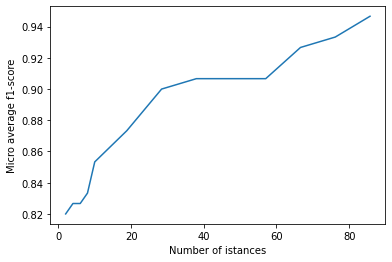

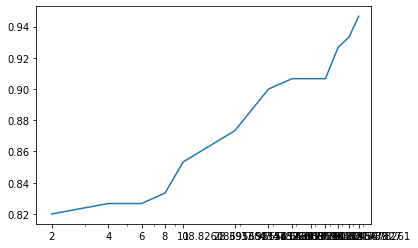

In [ ]:
x = [2, 4, 6, 8, 10, 18.82608695652174, 28.391304347826086, 37.95652173913044, 47.56521739130435, 57.04347826086956, 66.6086956521739, 76.17391304347827, 85.73913043478261]
y = [0.820000, 0.826667, 0.826667, 0.833333, 0.853333, 0.873333, 0.900000, 0.906667, 0.906667, 0.906667, 0.926667, 0.933333, 0.946667]
plt.plot(x,y)

plt.xlabel('Number of istances')
plt.ylabel('Micro average f1-score')

f,ax = plt.subplots()
ax.plot(x,y)
ax.set_xscale('log')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_xlim([0,100])

plt.show()